<a href="https://colab.research.google.com/github/javier-jaime/Tool-Crib/blob/master/Operations%20Research/Gurobi_Opti_101_Minimize_Electricity_Use.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizing Renewables and Energy Storage to Minimize Electricity Use

## Introduction

Using renewable energy has gained popularity with the adoption of solar and wind energy production technologies. Yet, the sun is not always shining and the wind is not always blowing. When customers need energy might not coincide with those of high wind and solar potential which is a key challenge associated with renewable energy sources. Batteries can be a solution to this problem making it possible to use energy that has been stored can be used at any time during the day by discharging the energy stored in the battery.

In this example, we will utilize solar energy along with battery storage to satisfy the energy demands of operating a university building and the associated courses that are taking place. In the next sections, we will describe the problem statement, and demonstrate how data science and mathematical optimization can be used to optimally solve the given problem.

The information used for this example have been adopted from [IEEE's Predict+Optimize Technical Challenge](https://ieee-dataport.org/competitions/ieee-cis-technical-challenge-predictoptimize-renewable-energy-scheduling).

## Objective and Prerequisites

In this example, we consider a single university building on campus that has a set of courses scheduled over the course of six days (Monday - Saturday).

The building and each course it holds have a certain energy demand that needs to be satisfied. The building's energy demand is assumed to known and each of the courses has a different demand based on the resources required (e.g. class size or a lab). The building has a solar panel installed which is capable of providing energy directly while there is also the ability of purchasing power directly from the electricity grid to satisfy the demand. Additionally, the building is equipped with two batteries which can store the energy provided from the solar panels, and can provide this energy when needed. We also allow for the batteries to be charged from the grid.

This example will integrate time series data forecasting with mathematical optimization as we will incorporate a solar generation forecast as the key input for an optimization problem.

## Problem Statement

Given a course schedule for the upcoming week and historical data about the solar potential, the objective is to determine the optimal battery charging and discharging schedule are in order to satisfy the energy demand for a building where the courses are held. The total energy demand is composed of the demand from the building itself plus the amount needed for each course. The example will look at two objectives:
- Minimize the total electricity purchased from the grid during the upcoming week
- Since electricity prices fluctuate, minimize the total cost of electricity purchased from the grid

At the same time, batteries have a finite capacity as well as limits on how much it can charge or discharge over a period of time. These impose constraints on the problem and make it difficult to solve.

For simplicity, the time considered for each day will be limited to between 5am and 8pm. If you have access to a full Gurobi license (e.g. through our [Academic Program](https://www.gurobi.com/academia/academic-program-and-licenses/)) feel free to expand this to solve a much larger version of the problem.

Here is a view of what the week's schedule will look like:
![sched](https://github.com/Gurobi/modeling-examples/blob/master/optimization101/Modeling_Session_2/ClassSchedule.png?raw=1)

## Solution Approach

The solution approach of the problem consists of two components: 1) **a forecasting component** for the solar availability and 2) **an optimization component** to determine the battery schedule as well as the amount of electricity purchased from the grid.

### Solar Power Forecasting

The forecasting component was completed in the [Creating Input for an Optimization Model](https://github.com/javier-jaime/Tool-Crib/blob/master/Operations%20Research/Gurobi_Opti_101_Creating_Input_for_an_Optimization_Model.ipynb) notebook in this repository. We'll use a given forecast from that model, as well as the demand of building and each of the courses to formulate and solve a mixed-integer programming (MIP) problem to find the optimal solution to the problem for each of the above objectives using gurobipy.

We begin our solution approach by installing and loading the necessary packages which will be needed:

### Optimal Battery Schedule
Now that we have a forecast of solar generation, we will create an optimization model that will schedule the charging and discharging of two batteries to help meet the building and course energy demand.

There are two batteries available that can be charged and discharged. Hence, we need an index to describe the existence and operation of each of the batteries. Finally, given that we would like to create the battery schedule in 30-minute intervals for the next month, we need to define an index for the time periods too.

**Sets**

$B = \{\texttt{Battery0, Battery1}\}$

$T = \{0,1,...,179\}$ for the first Monday through Saturday of October, 2020

**Indices**

$b$: denotes the battery (0 or 1)

$t$: denotes the time periods (from 0 to 179)

In [2]:
%pip install gurobipy
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

In [3]:
batteries = ["Battery0", "Battery1"]
# Read file from github
path = 'https://raw.githubusercontent.com/javier-jaime/Tool-Crib/master/Operations%20Research/Solar_Data/'
solar_values_read = pd.read_csv(path+'pred_solar_values.csv')
# upload file to session storage and remove comment
# solar_values_read = pd.read_csv('pred_solar_values.csv')
time_periods = range(len(solar_values_read))

### Input Parameters

Each of the batteries has a fixed capacity of how much energy it can store, as well as a maximum amount of energy that can be stored or discharged for each 30-minute period.

$c_{b}$: capacity of battery $b \in B \quad\quad \texttt{capacity[b]}$

$p_{b}$: loss of energy (as a percentage) during transfer into battery $b\in B \quad\quad \texttt{p}\_\texttt{loss[b]}$

$q_{b}$: quantity of initial energy in battery $b \in B \quad\quad \texttt{initial[b]}$

$solar_{t}$: solar power generation of the panel for time period $t \in T \quad\quad \texttt{solar}\_\texttt{values[b]}$

In [4]:
capacity = {"Battery0": 60, "Battery1": 80} # in Kw
p_loss = {"Battery0": 0.95, "Battery1": 0.9} # proportion
initial = {"Battery0": 0, "Battery1": 0} # in kW

solar_values = round(solar_values_read.yhat,3)
solar_values.reset_index(drop = True, inplace = True)

The energy demand at a particular time period comes from two sources -- the building and the class -- and we are only concerned with the total demand. This data will be read in from external files and are already ordered by time period correctly.

$d_{t}$: total building and class energy demand for time period $t\in T \quad\quad \texttt{total}\_\texttt{deamnd[t]}$

In [9]:
schedule = pd.read_csv(path+'schedule_demand.csv')
# schedule = pd.read_csv('schedule_demand.csv')
avg_building = pd.read_csv(path+'building_demand.csv')
# avg_building = pd.read_csv('building_demand.csv')
total_demand = schedule.sched_demand + avg_building.build_demand
print(f"Total Solar Generation: {solar_values.sum()} \nTotal Demand: {total_demand.sum()}")

Total Solar Generation: 4917.696 
Total Demand: 5250.6


### Decision Variables

The decisions for this problem are
- whether each battery is charged or discharged at a given time period
- how much to charge or discharge each battery
- the current state of the battery at a given time period
- as well as how much energy is purchased from the grid

Let $f^{in}_{b,t}$ be the amount each battery, $b$, can `charges` at time period,  $t$, $\forall b\in B, t\in T$. $\quad\quad \texttt{flow}\_\texttt{in[b,t]}$

Let $f^{out}_{b,t}$ be the amount each battery `discharges`, similarly. $\quad\quad \texttt{flow}\_\texttt{out[b,t]}$

Set the max amount that each battery can charge or discharge in a single period to be 20 kW.

In [13]:
m = gp.Model() #this defines the model that we'll add to as we finish the formulation

flow_in = m.addVars(batteries, time_periods, name="flow_in")
flow_out = m.addVars(batteries, time_periods, name="flow_out")

Next, there is the amount of energy that is purchased from the grid for each time period. We will assume this is a non-negative number and that we cannot "sell back" to the grid (although this is an interesting problem as well!)

$grid_{t}$ : This variable indicates the amount of energy purchased from the grid at time period, $t$, $\forall t \in T$

In [14]:
grid = m.addVars(time_periods, name="grid")

The next two sets of decision variables will have a slightly different feel to them. We need to keep track of the amount of energy that is in each battery (i.e. its state) over each time period and we need to track of how much solar energy is used (by charging or directly supplying energy).

$s_{b,t}$ is the current amount of energy in battery, $b$, at the end of time period, $t, \forall b\in B, t\in T$. $\quad\texttt{state[b,t]}$

$gen_{t}$ is the amount of available solar energy that is used in period $t$, $\forall t \in T$. $\quad\texttt{gen[t]}$


In [15]:
state = m.addVars(batteries, time_periods, name="state")
gen = m.addVars(time_periods, name="gen")

The last decision variables to add will take care of a tricky instance that can arise in a problem like this -- a battery cannot simultaneously charge and discharge. Thus, we need to make sure each battery, at each time period, will be doing one of three things: 1. **charge**, 2. **discharge**, or 3. **neither**.

To model this we introduce a binary variable for each time period, $z_{b,t}, \forall b \in B, t \in T$, which we'll call $\texttt{zwitch}\_\texttt{[b,t]}$. Why *zwitch*? It's something I've done since my early optimization modeling days since a common single letter used for binary variables used like this in MO is $z$. This variable acts like switch -- hence, *zwitch*.

In [16]:
zwitch = m.addVars(batteries, time_periods, vtype=GRB.BINARY, name="zwitch")

### Constraints
In each period, we need to make sure we meet energy demand. The available energy can come from three sources: 1) the grid, 2) solar panel, or 3) battery discharge. Additionally, we may decide to charge a battery which will help meet demand in a later period.

$$
\begin{align*}
\sum_b(f^{out}_{b,t}-p_bf^{in}_{b,t}) + gen_t + grid_t = d_t \quad \forall t \in T
\end{align*}
$$

In [17]:
m.addConstrs((gp.quicksum(flow_out[b,t] - p_loss[b]*flow_in[b,t] for b in batteries) + gen[t] + grid[t] == total_demand[t]
                  for t in time_periods), name="power_balance");

The state of each battery at a given time period affects the following state, along with the decision to charge or discharge each battery. So in general a battery's state at time $t$ is the state in the prior period and any charge or discharge.

To do this, we set an initial state based on any initial energy each battery has, along with the first time period's charge/discharge decision.

\begin{equation}
s_{b,0} = q_b + p_bf^{in}_{b,0} - f^{out}_{b,0}
\end{equation}

For each time period after (i.e. $t\ge1$), the state of a battery is found by:

\begin{equation}
s_{b,t} = s_{b,t-1} + p_bf^{in}_{b,t} - f^{out}_{b,t}, t \ge 1
\end{equation}

The respective constraints can be written as below.

In [18]:
m.addConstrs((state[b,0] == initial[b] + p_loss[b]*flow_in[b,0] - flow_out[b,0] for b in batteries), name="initial_state")
m.addConstrs((state[b,t] == state[b,t-1] + p_loss[b]*flow_in[b,t] - flow_out[b,t] for b in batteries for t in time_periods if t >= 1), name="subsequent_states");

The availability of solar energy can be used in three places:
1. Battery0
2. Battery1
3. Directly to satisfy demand

Because of this we need to limit the amount the batteries can charge along with the amount used directly for demand.

$$
\begin{equation}
f^{in}_{\texttt{Battery0},t} + f^{in}_{\texttt{Battery1},t} + gen_t \le solar_t, \quad \forall t \in T
\end{equation}
$$

In [19]:
m.addConstrs((flow_in['Battery0',t] + flow_in['Battery1',t] + gen[t] <= solar_values[t] for t in time_periods), name = "solar_avail");

### Binary Variables Modeling Logic
Using binary variables to model alternatives like what we have here is arguably the most difficult part of mathematical optimization modeling. It comes down to be able to represent a complex system using zeros, ones, and inequalities. To get the logic correct takes time and there is a lot of iteration at point to make sure it's done correctly. In short, do not worry if you find this part difficult.

Let's formulate the constraints and then dive into why they work.

$$
\begin{align*}
f^{in}_{b,t} &\leq 20*z_{b,t} &\forall b \in B, t \in T \\
f^{out}_{b,t} &\leq 20*(1-z_{b,t}) &\forall b \in B, t \in T
\end{align*}
$$

To illustrate how this works let's consider an example -- suppose for one of batteries $f^{in}_{b,t} = 10$ in a time period. For the first inequality to hold it is *necessary* that $z_{b,t} = 1$, otherwise it is $0$ and $20*0 = 0$, which can't happen if $f^{in}_{b,t} = 10$. Then for the same time period, if $z_{b,t} = 1$, then  $1-z_{b,t} = 0$. This forces the right-hand side of the second inequality to be $0$ and this forces $f^{out}_{b,t} = 0$ making it impossible to discharge during this period. Similar logic applies if the battery *discharges* during a period (i.e. suppose $f^{out}_{b,t} = 10$).

With our `zwitch` being a binary variable, that means one of the two above cases will *always* happen for each time period. The important question -- is this a problem? The answer is no, and that's because we need to worry about what our inequalities *force* decision variables to be. Consider the case when $f^{in}_{b,t} = f^{in}_{b,t} = 0$, meaning a battery is neither charging nor discharging since the flow in and out is zero. This case won't violate either of the inequalities above and doesn't matter which value $z$ takes -- it can be $0$ or $1$ and the inequalities hold.

This does raise an important point. If after solving this problem you were asked "How many periods did the battery charge and discharge?" It's easy to think that $z_{b,t} = 1$ means the battery is charging, so just add those up to get the number of charging periods. Then count the number of times if $z_{b,t} = 0$ to get the discharge count. This would be *incorrect* given what we saw when $f^{in}_{b,t} = f^{in}_{b,t} = 0$.

Where did the $20$ come from? It's the upper bound on the amount a battery can charge or discharge during a period.

In [20]:
m.addConstrs((flow_in[b,t] <= 20*zwitch[b,t] for b in batteries for t in time_periods), name = "to_charge")
m.addConstrs((flow_out[b,t] <= 20*(1-zwitch[b,t]) for b in batteries for t in time_periods), name = "or_not_to_charge");

Lastly, we need to set the max amount each battery can store, which means the battery's *state* must be bounded. These upper bounds can be set in the variable definition when using `addVars()`. Doing so there would require a list with the same dimensions as the decision variable. Below is another way to set the bound that quickly uses a `for` loop. For more info on all of the parameters you can set when adding variables see the [documentation]('https://www.gurobi.com/documentation/10.0/refman/py_model_addvars.html'). Generally, it's more efficient to set the bounds when adding the variables.

In [21]:
for b, t in state:
    state[b,t].UB = capacity[b]

$$
\begin{align*}
s_{b,t} \le c_b, \quad \forall b \in B
\end{align*}
$$

### Objective Function

The objective is to minimize the total amount of energy purchased from the grid over all time periods.

\begin{equation}
{\rm minimize} \quad \sum_{t} g_{t}
\end{equation}

In [22]:
m.setObjective(gp.quicksum(grid[t] for t in time_periods), GRB.MINIMIZE)

### Solving the Optimization Model and Output Analysis
With the model now set, we can optimize for minimal electricity purchased.

In [23]:
m.optimize()
print(f"Total energy purchased from the grid: {round(m.objVal,3)} kWh")

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1440 rows, 1800 columns and 4498 nonzeros
Model fingerprint: 0x7e94c9fe
Variable types: 1440 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e-01, 9e+01]
Found heuristic solution: objective 5250.6000000
Presolve removed 84 rows and 265 columns
Presolve time: 0.02s
Presolved: 1356 rows, 1535 columns, 4109 nonzeros
Found heuristic solution: objective 4991.1510000
Variable types: 1199 continuous, 336 integer (336 binary)

Root relaxation: objective 1.294073e+03, 617 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  D

Let's now take a look at the values of our some of the decision variables. The *getAttr* function along with the *'X'* argument is used to get the values of the `state` decision variables.

In [24]:
sol_in = pd.Series(m.getAttr('X',flow_in))
sol_out = pd.Series(m.getAttr('X',flow_out))
sol_level = pd.Series(m.getAttr('X',state))

print(f"Periods Battery0 charges: {sum(sol_in['Battery0'] > 0)}")
print(f"Periods Battery1 charges: {sum(sol_in['Battery1'] > 0)}")
print(f"Periods Battery0 discharges: {sum(sol_out['Battery0'] > 0)}")
print(f"Periods Battery1 discharges: {sum(sol_out['Battery1'] > 0)}")

Periods Battery0 charges: 48
Periods Battery1 charges: 30
Periods Battery0 discharges: 47
Periods Battery1 discharges: 20


A plot of each battery's state over the time:

Periods at Battery0 at Full Capacity: 19
Periods at Battery1 at Full Capacity: 12


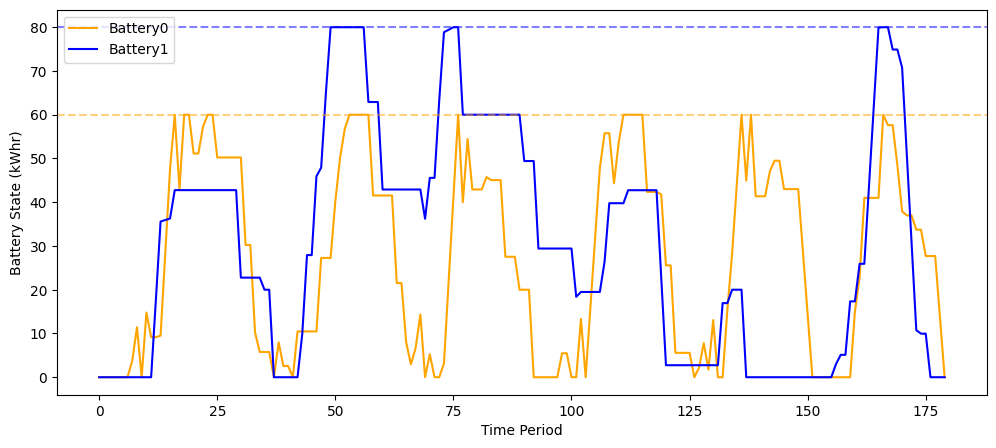

In [25]:
plt.figure(figsize=(12,5))
s0, = plt.plot(sol_level['Battery0'], c = 'orange')
s1, = plt.plot(sol_level['Battery1'], c = 'blue')
plt.ylabel('Battery State (kWhr)')
plt.xlabel('Time Period')
plt.legend([s0,s1],["Battery0", "Battery1"])
plt.axhline(y=capacity['Battery0'], c='orange', linestyle='--', alpha = 0.5)
plt.axhline(y=capacity['Battery1'], c='blue', linestyle='--', alpha = 0.5)
print(f"Periods at Battery0 at Full Capacity: {sum(sol_level['Battery0']==capacity['Battery0'])}")
print(f"Periods at Battery1 at Full Capacity: {sum(sol_level['Battery1']==capacity['Battery1'])}");

Using the default capacity values, the smaller capacity battery (Battery0) hits its capacity only twice while Battery1 hits its limit more often. How would changes to these values change the optimization?

Our last set of decision variables is the amount of electricity to buy from the grid, in which the total was minimized in the objective, and plot that over time.

Proportion of time periods where electrity is purchaced from the grid: 0.45


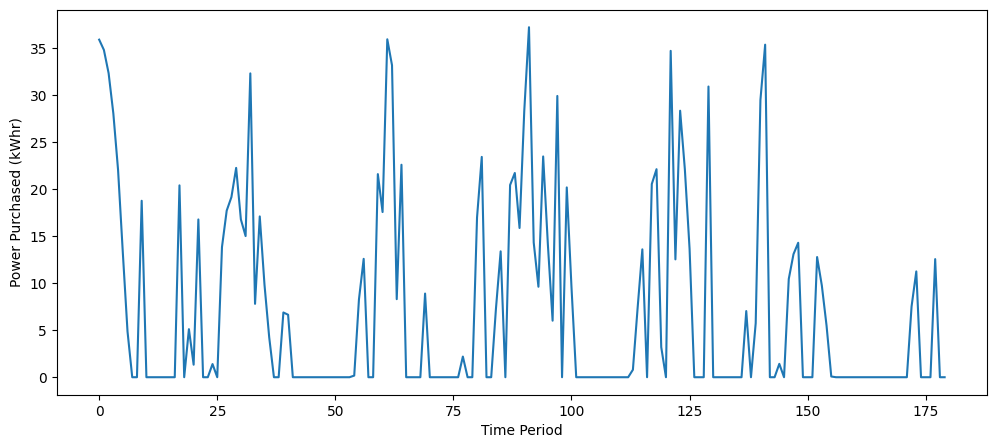

In [26]:
sol_grid = pd.Series(m.getAttr('X',grid))
plt.figure(figsize=(12,5))
plt.plot(sol_grid)
plt.ylabel('Power Purchased (kWhr)')
plt.xlabel('Time Period');
print(f"Proportion of time periods where electrity is purchaced from the grid: {round(sum(sol_grid > 0)/len(sol_grid),3)}")

Above, the number of periods where electricity was purchased from the grid was calculated. Is this the same as minimizing the total amount purchased? If not (hint, it's not!), how would you model that? (Another hint, that would require additional binary variables)
### Changing the Objective Function
As mentioned at the beginning of the example, we'll consider two objective functions with the second minimizing the cost of electricity purchaced. To do that, we need anticipated prices for each time period.

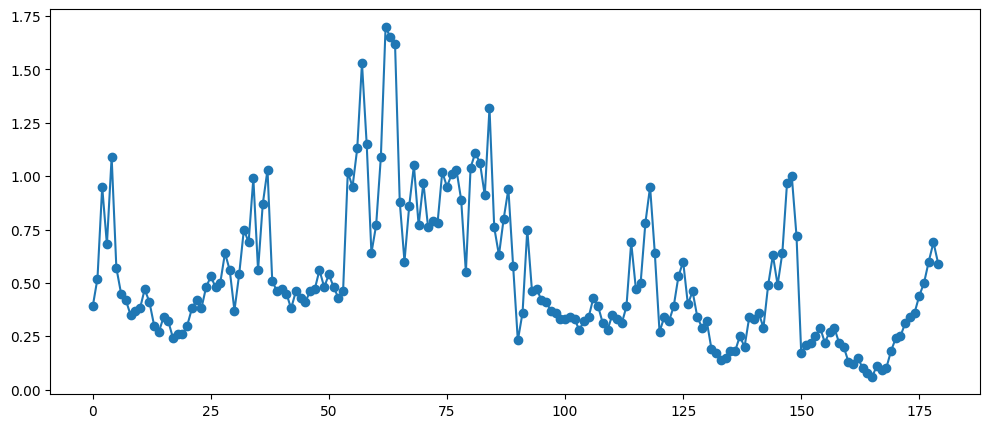

In [27]:
avg_price = pd.read_csv(path+'expected_price.csv')
# avg_price = pd.read_csv('expected_price.csv')
plt.figure(figsize=(12,5))
plt.plot(avg_price.index, avg_price.price, '-o');

To change the objective, it just needs to be set again. The rest of the model stays the same so no further adjustments are needed.

In [28]:
m.setObjective(gp.quicksum(avg_price.price[time]*grid[time] for time in time_periods), GRB.MINIMIZE)

In [29]:
m.optimize() # run the optimization again
print(f"Energy cost for the week: ${round(m.objVal,2)}")

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1440 rows, 1800 columns and 4498 nonzeros
Model fingerprint: 0x61947127
Variable types: 1440 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [6e-02, 2e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e-01, 9e+01]

MIP start from previous solve produced solution with objective 615.995 (0.04s)
MIP start from previous solve produced solution with objective 615.995 (0.05s)
Loaded MIP start from previous solve with objective 615.995

Presolve removed 84 rows and 265 columns
Presolve time: 0.02s
Presolved: 1356 rows, 1535 columns, 4109 nonzeros
Variable types: 1199 continuous, 336 integer (336 binary)

Root relaxation: objective 6.074759e+02, 732 iterations, 0.02 

We can extract the decision variables as before to see how the solution changes given the new objective.

Periods at Battery0 at Full Capacity: 29
Periods at Battery1 at Full Capacity: 18


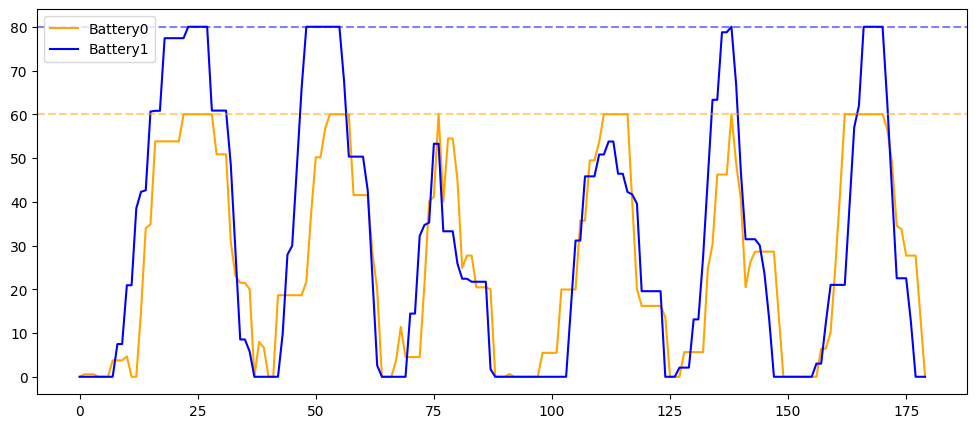

In [30]:
sol_level_cost = pd.Series(m.getAttr('X',state))
plt.figure(figsize=(12,5))
plt.plot(sol_level_cost['Battery0'], c ='orange')
plt.plot(sol_level_cost['Battery1'], c ='blue')
plt.legend([s0,s1],["Battery0", "Battery1"])
plt.axhline(y=capacity['Battery0'], c='orange', linestyle='--', alpha = 0.5)
plt.axhline(y=capacity['Battery1'], c='blue', linestyle='--', alpha = 0.5)
print(f"Periods at Battery0 at Full Capacity: {sum(sol_level_cost['Battery0']==capacity['Battery0'])}")
print(f"Periods at Battery1 at Full Capacity: {sum(sol_level_cost['Battery1']==capacity['Battery1'])}");

We see that each battery spends more time full or near-full, particuarly Battery0. This shows how adding cost will make batteries hold on to electricity to then be discharged during time periods where the cost is highest.

Here are some follow-on questions to take a deeper dive into this problem:
- How much electricity was purchased from the grid after changing the objective?
- Given the prices used for the seconds objective, what would the cost have been for the first solution that minimized electricity purchased?
- How would increasing the capacity of Battery0 in the second objective change the solution?

<h2>Conclusion</h2>

This example walked through an instance of how to model an energy system that leverages a time series forecast of solar availability. Part of the challenge in modeling such systems is how decisions from one time periods impact the next. We also looked at two ways to define a decision variables bounds and saw that updating an objective function is very straightforward, possibly having a big impact on the solution. There are more [energy related](https://www.gurobi.com/resource/electrical-power-generation-jupyter-notebook-i-and-ii/) examples in Gurobi's extensive set of [notebook examples](https://www.gurobi.com/resource/modeling-examples-using-the-gurobi-python-api-in-jupyter-notebook/).

Copyright © 2022 Gurobi Optimization, LLC